In [1]:
import lstm
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import sys
import pandas as pd
from pandas import Series, DataFrame, Panel
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
import re
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.stats import logistic
%matplotlib inline
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 24
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size
keras.backend.image_dim_ordering()

Using TensorFlow backend.


Current size: [6.0, 4.0]


'tf'

In [2]:
class BatchGenerator:
    
    def __init__(self, file, time_steps=48, scaler_type='standard', pca=False, pca_dim=8, normal=False):
        self.file = file
        self.time_steps = time_steps
        self.scaler_type = scaler_type
        self.pca = pca
        self.pca_dim = pca_dim
        self.normal = normal
        
        print ("Loading data ...")
        data_loaded = pd.read_pickle(self.file)
        data_loaded.isnull().sum()
        
        # load data
        data_loaded_np = data_loaded[["PM2.5","WS","RH","BP","VWS","SR","WD","TEMP"]].as_matrix()
        
        # Standardization of output pm25 only
#         pm25_ori = data_loaded_np[0:,0]
#         print(np.shape(pm25_ori))
#         pm25_ori = pm25_ori.reshape((len(pm25_ori), 1))
#         self.scale_output = StandardScaler()
#         pm25_ori = self.scale_output.fit_transform(pm25_ori)
#         print(np.shape(pm25_ori))
#         pm25_ori = pm25_ori.reshape(-1)
#         self.X_norm_ori_pm, self.y_norm_ori_pm = self.generate_batch_data(pm25_ori, time_steps=self.time_steps, name="pm25_ori")
        
        # Standardization of complete dataset
#         data_loaded_np = self.scaler.fit_transform(data_loaded_np)
       
        # PCA
        if self.pca == True:
            print("PCA transform")
            pca = PCA(n_components=self.pca_dim, svd_solver='full')
            pca = pca.fit(data_loaded_np)
            data_loaded_np = pca.transform(data_loaded_np)
        
        #Row Normalization    
        if self.normal == True:
            print("Normalize transform")
            self.norm_scaler = Normalizer().fit(data_loaded_np)
            data_loaded_np = self.norm_scaler.transform(data_loaded_np)

        self.X_norm_pm, self.y_norm_pm, self.scaler_pm = self.generate_batch_data(data_loaded_np[0:,0], time_steps=self.time_steps, name="pm25")
        self.X_norm_ws, self.y_norm_ws, self.scaler_ws = self.generate_batch_data(data_loaded_np[0:,1], time_steps=self.time_steps, name="ws")
        self.X_norm_rh, self.y_norm_rh, self.scaler_rh = self.generate_batch_data(data_loaded_np[0:,2], time_steps=self.time_steps, name="rh")
        self.X_norm_bp, self.y_norm_bp, self.scaler_bp = self.generate_batch_data(data_loaded_np[0:,3], time_steps=self.time_steps, name="bp")
        self.X_norm_vws, self.y_norm_vws, self.scaler_vws = self.generate_batch_data(data_loaded_np[0:,4], time_steps=self.time_steps, name="vws")
        self.X_norm_sr, self.y_norm_sr, self.scaler_sr = self.generate_batch_data(data_loaded_np[0:,5], time_steps=self.time_steps, name="sr")
        self.X_norm_wd, self.y_norm_wd, self.scaler_wd = self.generate_batch_data(data_loaded_np[0:,6], time_steps=self.time_steps, name="wd")
        self.X_norm_temp, self.y_norm_temp, self.scaler_temp = self.generate_batch_data(data_loaded_np[0:,7], time_steps=self.time_steps, name="temp")

        if not (self.scaler_type is None):
            filename = "np_"+self.scaler_type+"_process_comp_"+str(self.time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"
        else:
            filename = "np_process_comp_"+str(self.time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"

        if os.path.isfile("data_log/"+filename):
            print ("Found existing file :","data_log/"+filename)
            print ("Loading ...")
            npzfile = np.load("data_log/"+filename)
            self.X_norm_pm = npzfile['arr_0']
            self.X = npzfile['arr_1']
            self.Y = npzfile['arr_2']
            print ("Complete.")
        else:
            self.X = np.array(np.zeros([1, 7]))
            for i in range(len(self.X_norm_pm)):
                temp = np.column_stack((self.X_norm_ws[i],self.X_norm_rh[i],self.X_norm_bp[i],self.X_norm_vws[i],self.X_norm_sr[i],self.X_norm_wd[i],self.X_norm_temp[i]))
                self.X = np.append(self.X, temp, axis=0)

            self.X = self.X[1:].reshape(len(self.X_norm_pm),48,7)
#             self.Y = self.y_norm_ori_pm
            self.Y = self.y_norm_pm 

            print ("Input shape :",np.shape(self.X_norm_pm))
            print ("Aux Input shape :",np.shape(self.X))
            print ("Output shape :",np.shape(self.Y))
            print ("Saving file ...")
            np.savez("data_log/"+filename, self.X_norm_pm, self.X, self.Y)
            print ("Saved file to :", filename)
            print ("Complete.")
        
    def return_data(self):
        return self.X_norm_pm, self.X, self.Y, self.scaler_pm

    def shift(self, arr, num, fill_value=np.nan):
        result = np.empty_like(arr)
        if num > 0:
            result[:num] = fill_value
            result[num:] = arr[:-num]
        elif num < 0:
            result[num:] = fill_value
            result[:num] = arr[-num:]
        else:
            result = arr
        return result

    def generate_batch_data(self, raw_data, time_steps, name):
        series = pd.Series(raw_data, dtype=np.float32)
        values = series.values
        values = values.reshape((len(values), 1))
        print('feature ------------ ', name.upper())
        
        if self.scaler_type == 'standard':
            scaler = StandardScaler()
        if self.scaler_type == 'robust':
            scaler = RobustScaler()
        if self.scaler_type == 'min_max':
            scaler = MinMaxScaler(feature_range=(0, 1))
            
        scaler = scaler.fit(values)
        normalized = scaler.transform(values)
        
        #data = values
        data = normalized
        print('Max: %f, Min: %f' % (np.amax(data), np.amin(data)))
        x = data[:(len(data)-(len(data) % time_steps))]
        y = self.shift(data,-(time_steps)).astype(np.float32)

        x_batches = np.array([])
        y_batches = np.array([])

        # check if file exists
        if (self.scaler_type is None):
            seq_file_name = "np_processed_"+name+"_"+str(time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"
        else:
            seq_file_name = "np_"+self.scaler_type+"_processed_"+name+"_"+str(time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"          

        if os.path.isfile("data_log/"+seq_file_name):
            npzfile = np.load("data_log/"+seq_file_name)
            x_batches = npzfile['arr_0']
            y_batches = npzfile['arr_1']
            return x_batches, y_batches, scaler
        else: 
            for i in range(len(y)):
                try:
                    x_batches = np.append(x_batches, x[i:i+(time_steps)].reshape(-1,12,1))
                    y_batches = np.append(y_batches, y[i].reshape(-1))
                except ValueError:
                    break
                    
            x_batches = x_batches.reshape(-1, time_steps, 1)
            y_batches = y_batches.reshape(-1)
            np.savez("data_log/"+seq_file_name, x_batches, y_batches)
            return x_batches, y_batches, scaler

In [3]:
if __name__=='__main__':
    epochs  = 150
    state_neurons_1 = 1024
    state_neurons_2 = 1024
    state_neurons_3 = 1024
    output = 1
    seed = 7
    batch_size = 32
    scaler_type="standard"
    dropouts = [0.15, 0.25, 0.45]
    seq_len = 48
    file_name = "wt_LSTM_Keras_tanh_rmsprop_"+scaler_type+"_dp("+"_".join(str(x) for x in dropouts)+")_"+str(epochs)+"_"+str(seq_len)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(batch_size)

    batch_generator_obj = BatchGenerator(file="data_log/mumbai_6_log_pro.pkl", time_steps=48, scaler_type=scaler_type, pca=False, pca_dim=8, normal=False)
    X_norm, X_aux_norm, y_norm, scaler = batch_generator_obj.return_data()
    X_train, X_val, X_aux_train, X_aux_val, y_train, y_val = train_test_split(X_norm, X_aux_norm, y_norm, test_size=0.20, random_state=seed)
    
    #recreate model 
    model = lstm.build_model([4, 7], [7, seq_len, state_neurons_1, state_neurons_2, output], dropouts, pre_train=file_name+".h5")
    print("Created model and loaded weights from "+file_name+".h5")
    
    # estimate accuracy on whole dataset using loaded weights
    _y_val = lstm.predict_point_by_point_aux(model, [X_val, X_aux_val])
#     _y_test = lstm.predict_point_by_point_aux(model,  [X_test, X_aux_test])
    
    _y_val = _y_val.reshape(-1,1)
#     _y_test = _y_test.reshape(-1,1)
    
    y_val = y_val.reshape(-1,1)
#     y_test = y_test.reshape(-1,1)
    
    #inverse the predictions to its actual value
    print("Predicted Output sample: ")
    _y_va = scaler.inverse_transform(_y_val)
#     _y_te = scaler.inverse_transform(_y_test)
    for i in range(5):
        print(_y_va[i])
    
    #inverse the outputs to its actual value
    print("Original Output sample: ")
    y_va = scaler.inverse_transform(y_val)
#     y_te = scaler.inverse_transform(y_test)
    for i in range(5):
        print(y_va[i])    
    
    y_va = np.exp(y_va)
    _y_va = np.exp(_y_va)
    
    #predicted
    _Y_VA = pd.Series(np.ravel(_y_va))
#     _Y_TE = pd.Series(np.ravel(_y_te))
    
    #original
    Y_VA = pd.Series(np.ravel(y_va))
#     Y_TE = pd.Series(np.ravel(y_te))

Loading data ...
feature ------------  PM25
Max: 3.284291, Min: -10.752898
feature ------------  WS
Max: 3.415116, Min: -2.449860
feature ------------  RH
Max: 1.363076, Min: -4.063657
feature ------------  BP
Max: 5.360242, Min: -7.499539
feature ------------  VWS
Max: 9.401879, Min: -11.963299
feature ------------  SR
Max: 1.637784, Min: -2.654759
feature ------------  WD
Max: 1.076242, Min: -6.484889
feature ------------  TEMP
Max: 3.006956, Min: -3.982146
Found existing file : data_log/np_standard_process_comp_48_False_False.npz
Loading ...
Complete.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 48, 1)        0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 48, 

Validation RMSE : 18.780040112445164


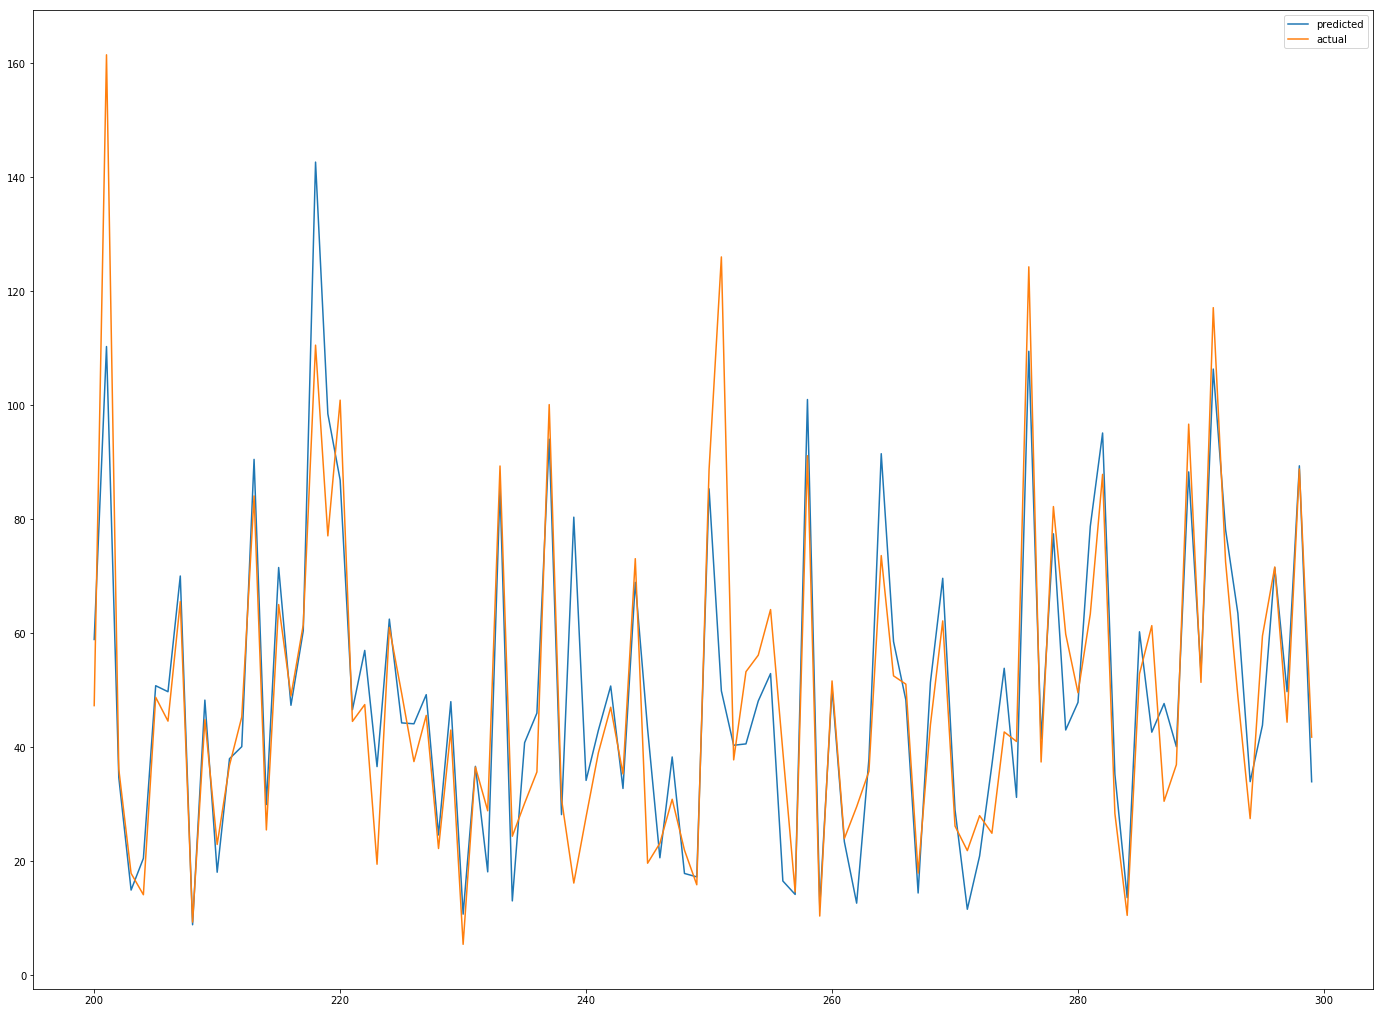

In [4]:
if __name__=='__main__':
    print('Validation RMSE :', math.sqrt(mean_squared_error(_Y_VA, Y_VA)))
    plot_predicted, = plt.plot(_Y_VA[200:300], label='predicted')
    plot_train, = plt.plot(Y_VA[200:300], label='actual')
    plt.legend(handles=[plot_predicted, plot_train])

In [5]:
# class BatchGenerator:
    
#     def __init__(self, file, time_steps=48, scaler_type='standard', pca=False, pca_dim=8, normal=False):
#         self.file = file
#         self.time_steps = time_steps
#         self.scaler_type = scaler_type
#         self.pca = pca
#         self.pca_dim = pca_dim
#         self.normal = normal
        
#         print ("Loading data ...")
#         data_loaded = pd.read_pickle(self.file)
#         data_loaded.isnull().sum()
       
#         # Choose Standardization
#         if self.scaler_type == 'standard':
#             self.scaler = StandardScaler()
#             print('Data normalized... Using Standard Scaling')
#         if self.scaler_type == 'robust':
#             self.scaler = RobustScaler()
#             print('Data normalized... Using Robust Scaling')
#         if self.scaler_type == 'min_max':
#             self.scaler = MinMaxScaler(feature_range=(0, 1))
#             print('Data normalized... Using Min-Max Scaling')
        
#         # load data
#         data_loaded_np = data_loaded[["PM2.5","WS","RH","BP","VWS","SR","WD","TEMP"]].as_matrix()
        
#         # Standardization of output pm25 only
#         pm25_ori = data_loaded_np[0:,0]
#         print(np.shape(pm25_ori))
#         pm25_ori = pm25_ori.reshape((len(pm25_ori), 1))
#         self.scale_output = StandardScaler()
#         pm25_ori = self.scale_output.fit_transform(pm25_ori)
#         print(np.shape(pm25_ori))
#         pm25_ori = pm25_ori.reshape(-1)
#         self.X_norm_ori_pm, self.y_norm_ori_pm = self.generate_batch_data(pm25_ori, time_steps=self.time_steps, name="pm25_ori")
        
#         # Standardization of complete dataset
#         data_loaded_np = self.scaler.fit_transform(data_loaded_np)
       
#         # PCA
#         if self.pca == True:
#             print("PCA transform")
#             pca = PCA(n_components=self.pca_dim, svd_solver='full')
#             pca = pca.fit(data_loaded_np)
#             data_loaded_np = pca.transform(data_loaded_np)
        
#         #Row Normalization    
#         if self.normal == True:
#             print("Normalize transform")
#             self.norm_scaler = Normalizer().fit(data_loaded_np)
#             data_loaded_np = self.norm_scaler.transform(data_loaded_np)

#         self.X_norm_pm, self.y_norm_pm = self.generate_batch_data(data_loaded_np[0:,0], time_steps=self.time_steps, name="pm25")
#         self.X_norm_ws, self.y_norm_ws = self.generate_batch_data(data_loaded_np[0:,1], time_steps=self.time_steps, name="ws")
#         self.X_norm_rh, self.y_norm_rh = self.generate_batch_data(data_loaded_np[0:,2], time_steps=self.time_steps, name="rh")
#         self.X_norm_bp, self.y_norm_bp = self.generate_batch_data(data_loaded_np[0:,3], time_steps=self.time_steps, name="bp")
#         self.X_norm_vws, self.y_norm_vws = self.generate_batch_data(data_loaded_np[0:,4], time_steps=self.time_steps, name="vws")
#         self.X_norm_sr, self.y_norm_sr = self.generate_batch_data(data_loaded_np[0:,5], time_steps=self.time_steps, name="sr")
#         self.X_norm_wd, self.y_norm_wd = self.generate_batch_data(data_loaded_np[0:,6], time_steps=self.time_steps, name="wd")
#         self.X_norm_temp, self.y_norm_temp = self.generate_batch_data(data_loaded_np[0:,7], time_steps=self.time_steps, name="temp")

#         if not (self.scaler_type is None):
#             filename = "np_"+self.scaler_type+"_process_comp_"+str(self.time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"
#         else:
#             filename = "np_process_comp_"+str(self.time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"

#         if os.path.isfile("data_log/"+filename):
#             print ("Found existing file :","data_log/"+filename)
#             print ("Loading ...")
#             npzfile = np.load("data_log/"+filename)
#             self.X_norm_pm = npzfile['arr_0']
#             self.X = npzfile['arr_1']
#             self.Y = npzfile['arr_2']
#             print ("Complete.")
#         else:
#             self.X = np.array(np.zeros([1, 7]))
#             for i in range(len(self.X_norm_pm)):
#                 temp = np.column_stack((self.X_norm_ws[i],self.X_norm_rh[i],self.X_norm_bp[i],self.X_norm_vws[i],self.X_norm_sr[i],self.X_norm_wd[i],self.X_norm_temp[i]))
#                 self.X = np.append(self.X, temp, axis=0)

#             self.X = self.X[1:].reshape(len(self.X_norm_pm),48,7)
# #             self.Y = self.y_norm_ori_pm
#             self.Y = self.y_norm_pm 

#             print ("Input shape :",np.shape(self.X_norm_pm))
#             print ("Aux Input shape :",np.shape(self.X))
#             print ("Output shape :",np.shape(self.Y))
#             print ("Saving file ...")
#             np.savez("data_log/"+filename, self.X_norm_pm, self.X, self.Y)
#             print ("Saved file to :", filename)
#             print ("Complete.")
        
#     def return_data(self):
#         return self.X_norm_pm, self.X, self.Y, self.scaler

#     def shift(self, arr, num, fill_value=np.nan):
#         result = np.empty_like(arr)
#         if num > 0:
#             result[:num] = fill_value
#             result[num:] = arr[:-num]
#         elif num < 0:
#             result[num:] = fill_value
#             result[:num] = arr[-num:]
#         else:
#             result = arr
#         return result

#     def generate_batch_data(self, raw_data, time_steps, name):
#         series = pd.Series(raw_data, dtype=np.float32)
#         values = series.values
#         values = values.reshape((len(values), 1))
#         print('feature ------------ ', name.upper())
        
#         # batch formation
#         data = values
#         print('Max: %f, Min: %f' % (np.amax(data), np.amin(data)))
#         x = data[:(len(data)-(len(data) % time_steps))]
#         y = self.shift(data,-(time_steps)).astype(np.float32)

#         x_batches = np.array([])
#         y_batches = np.array([])

#         # check if file exists
#         if (self.scaler_type is None):
#             seq_file_name = "np_processed_"+name+"_"+str(time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"
#         else:
#             seq_file_name = "np_"+self.scaler_type+"_processed_"+name+"_"+str(time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"          

#         if os.path.isfile("data_log/"+seq_file_name):
#             npzfile = np.load("data_log/"+seq_file_name)
#             x_batches = npzfile['arr_0']
#             y_batches = npzfile['arr_1']
#             return x_batches, y_batches
#         else: 
#             for i in range(len(y)):
#                 try:
#                     x_batches = np.append(x_batches, x[i:i+(time_steps)].reshape(-1,12,1))
#                     y_batches = np.append(y_batches, y[i].reshape(-1))
#                 except ValueError:
#                     break
                    
#             x_batches = x_batches.reshape(-1, time_steps, 1)
#             y_batches = y_batches.reshape(-1)
#             np.savez("data_log/"+seq_file_name, x_batches, y_batches)
#             return x_batches, y_batches